# Qiskit Implementation for Grover Search

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

In [5]:
n=4

In [6]:
#グラフ
G = [
    [1, 2, 3],
    [0, 2, 3],
    [0, 1, 3],
    [0, 1, 2]
]
'''
G = [
    [1, 2, 3, 4],
    [0, 2, 3, 5, 6],
    [0, 1, 4, 5, 7],
    [0, 1, 4, 6, 8],
    [0, 2, 3, 7, 8],
    [1, 2, 6, 7],
    [1, 3, 5, 8],
    [2, 4, 5, 8],
    [3, 4, 6, 7]
]
'''
m = 0
for v in range(n):
    m += len(G[v])
m //= 2 #辺数
print(m) 

6


### $\dagger$古典全探索$\dagger$

In [7]:
def bit_to_color(bit):
    color = [0]
    for i in range(n - 1):
        color.append(bit % 4)
        bit //= 4
    return color

def oracle_classic(bit):
    color = bit_to_color(bit)
    
    for v in range(n):
        for u in G[v]:
            if color[u] == color[v]:
                return False
    return True

def stupid_brute_force():
    coloring = []
    for bit in range(2 ** (2 * n - 2)):
        if oracle_classic(bit):
            coloring.append(bit_to_color(bit))
    return coloring
            
coloring = stupid_brute_force()
print(len(coloring), 2 ** (2 * n - 2), coloring)

6 64 [[0, 3, 2, 1], [0, 2, 3, 1], [0, 3, 1, 2], [0, 1, 3, 2], [0, 2, 1, 3], [0, 1, 2, 3]]


### Write down an oracle function for the problem. Note that x1 represents the color of region 1, and you can use logical operators including ≠ (not equal) and ∧ (AND).

In [8]:
def oracle_logical():
    res = ''
    for v in range(n):
        for u in G[v]:
            if v < u:
                if v == 0:
                    res += '(0 ≠ ' + 'x' + str(u) + ')'
                    res += '∧'
                elif v < u:
                    res += '(x' + str(v) + ' ≠ x' + str(u) + ')'
                    res += '∧'
    print(res[0:-1])

oracle_logical()
                

(0 ≠ x1)∧(0 ≠ x2)∧(0 ≠ x3)∧(x1 ≠ x2)∧(x1 ≠ x3)∧(x2 ≠ x3)


In [9]:
qr = QuantumRegister(2 * n - 2, 'q')
cond = QuantumRegister(m, 'cond')
anc = QuantumRegister(1, 'ancilla')
grover_circuit = QuantumCircuit(qr, cond, anc)

In [10]:
def initialization():
    # For input qubits
    grover_circuit.h(qr)
    # For the ancilla bit
    grover_circuit.x(anc)
    grover_circuit.h(anc)
    grover_circuit.barrier()

In [11]:
def diffusion():
    # input_qubits = 2 * n - 2
    grover_circuit.h(qr)
    grover_circuit.x(qr)
    grover_circuit.h(qr[-1])
    grover_circuit.mct(qr[0:-1], qr[-1])
    grover_circuit.h(qr[-1])
    grover_circuit.x(qr)
    grover_circuit.h(qr)
    grover_circuit.barrier()

### Create an oracle quantum circuit for the problem using Qiskit. Note that an oracle quantum circuit needs to change the phase of the good states.

In [12]:
## TODO
def oracle():
    def add_edges():
        edge_at = 0
        for v in range(n):
            for u in G[v]:
                if v == 0:
                    grover_circuit.x(qr[(u - 1) * 2])
                    grover_circuit.x(qr[(u - 1) * 2 + 1])
                    grover_circuit.mct(qr[(u - 1) * 2 : (u - 1) * 2 + 2], cond[edge_at])
                    grover_circuit.x(cond[edge_at])
                    grover_circuit.x(qr[(u - 1) * 2])
                    grover_circuit.x(qr[(u - 1) * 2 + 1])
                    edge_at += 1
                elif v < u:
                    grover_circuit.cx(qr[(v - 1) * 2], qr[(u - 1) * 2])
                    grover_circuit.cx(qr[(v - 1) * 2 + 1], qr[(u - 1) * 2 + 1])
                    grover_circuit.x(qr[(u - 1) * 2 : (u - 1) * 2 + 2])
                    grover_circuit.mct(qr[(u - 1) * 2 : (u - 1) * 2 + 2], cond[edge_at])
                    grover_circuit.x(cond[edge_at])
                    grover_circuit.x(qr[(u - 1) * 2 : (u - 1) * 2 + 2])
                    grover_circuit.cx(qr[(v - 1) * 2], qr[(u - 1) * 2])
                    grover_circuit.cx(qr[(v - 1) * 2 + 1], qr[(u - 1) * 2 + 1])
                    edge_at += 1
                
                
    add_edges()
    grover_circuit.mct(cond, anc)
    add_edges()
    grover_circuit.barrier()

In [13]:
##オラクル出力
# oracle_circuit = QuantumCircuit(qr, anc)
# oracle(oracle_circuit)
# oracle_circuit.draw('mpl')

### With the oracle created in the above, create a quantum circuit to solve the problem with Grover's search (use 5 for the number of iteration in Grover's search) and run it on.

In [17]:
num_iterations = 3

In [18]:
# Let's do Grover search
grover_circuit = QuantumCircuit(qr, cond, anc) #行儀良くない

initialization()

for i in range(0, num_iterations):
    oracle()
    diffusion()
    
# Clear the ancilla bit
grover_circuit.h(anc)
grover_circuit.x(anc)

##回路全体出力    
# grover_circuit.draw('mpl')

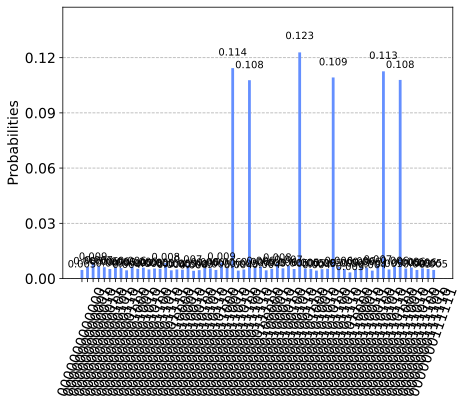

In [19]:
grover_circuit.measure_all()

backend = Aer.get_backend('qasm_simulator')
shots = 8092
results = execute(grover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

### Enumerate all the feasible assignments of colors.

In [22]:
threshold = 0.09 * shots

valid_coloring = []
for key in answer:
    if answer[key] > threshold:
        valid_coloring.append(bit_to_color(int(key, 2)))
        
print(valid_coloring)

[[0, 2, 1, 3], [0, 1, 2, 3], [0, 2, 3, 1], [0, 3, 1, 2], [0, 1, 3, 2], [0, 3, 2, 1]]


### 実機

In [33]:
IBMQ.load_account()
provider = IBMQ.get_provider(group = 'open')
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_lima


In [31]:
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job has successfully run


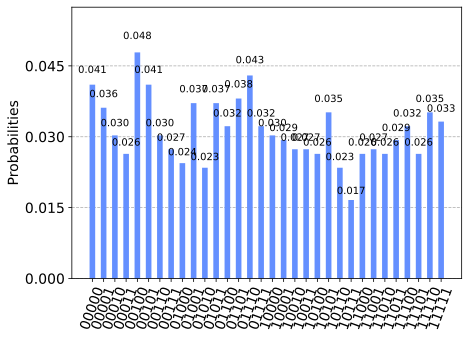

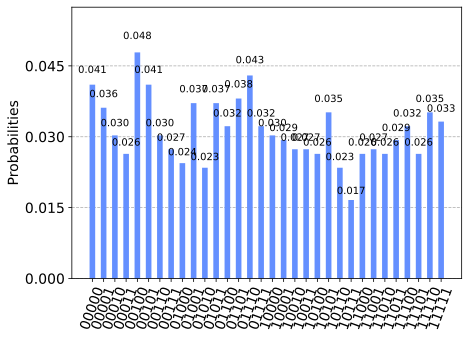

In [32]:
# Check the results of the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)